# Cold air composite from my own binary cold air event data
### Notes: 
also look at u and v components seperately

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pymannkendall
import eofs.xarray


## load jet winds data

In [2]:
# zg = xr.open_dataset('/home/thomaskeel/Dev/PhD/jsmetrics/data/era5_zg_79to21.nc')

In [3]:
zg = xr.open_dataset('/home/thomaskeel/Dev/Climate Data/ERA-5/era5_PV_500hPa_79to23.nc')

In [4]:
zg = zg.rename({'longitude':'lon', 'latitude':'lat', 'pv':'z'})
zg['lon'] = (zg['lon'] + 360) % 360

In [5]:
zg = zg.sortby('lon')

In [6]:
k06 = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_*100to400*.nc') # before: 

In [7]:
pna_index = pd.read_csv('../data/climate_indices/norm.daily.pna.cdas.z500.19500101_current.csv')
pna_index['time'] = pd.to_datetime(pna_index[['year', 'month', 'day']])
pna_index = pna_index.set_index('time')
pna_index = pna_index[:"2023-03"]
pna_index = pna_index.drop(['year', 'month', 'day'], axis=1)
pna_index = pna_index.rename(columns={'pna_index_cdas':'PNA'})

In [8]:
pna_below_1sd = pna_index['PNA'] < (pna_index.mean()['PNA'] - pna_index.std()['PNA'])
dates_below_1sd = pna_below_1sd.where(lambda row: row).dropna().index

### normalise data

In [9]:
KOCH_WS_MONTH_MEAN = k06['weighted_average_ws'].groupby('time.month').mean('time')

In [10]:
def normalise_data(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
    
# def get_formatted_koch_imgs_normalised(row):
#     row = normalise_data(row.values.astype(float))
#     return row


def get_month_anom(row):
    row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

# def get_formatted_koch_imgs_normalised_month_anom_relative(row):
#     row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
#     row_month_anom = normalise_data(row_month_anom.values.astype(float))
#     return row_month_anom

In [11]:
%%time
k06['weighted_average_ws'].load();

CPU times: user 529 ms, sys: 1.55 s, total: 2.08 s
Wall time: 2.72 s


In [12]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc'):
    print('loading norm data')
    k06['jet_events_ws_norm'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')
else:
    print('making norm data')
    k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)

loading norm data
CPU times: user 17.9 ms, sys: 3.07 ms, total: 20.9 ms
Wall time: 30.1 ms


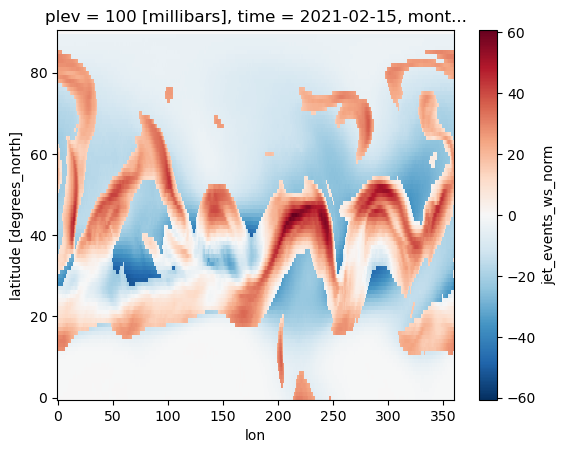

In [13]:
k06['jet_events_ws_norm'].sel(time="2021-02-15").plot()

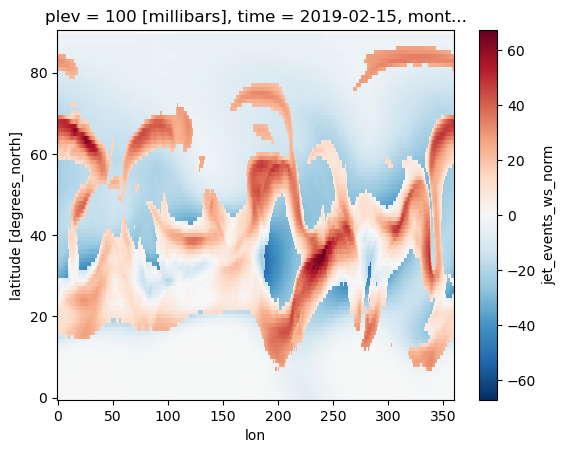

In [14]:
k06['jet_events_ws_norm'].sel(time="2019-02-15").plot()

In [15]:
# k06['jet_events_ws_norm'].to_netcdf('../data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')

# load extreme ('persistent') cold data

In [16]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

In [17]:
extreme_cold_persist_thresh['cold_air_event_CNA'].to_pandas().value_counts()

0    29525
1      910
dtype: int64

In [18]:
extreme_cold_persist_thresh.sel(time="2021-02")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 28)>
array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 2021-02-02 ... 2021-02-28
    dayofyear  (time) int64 32 33 34 35 36 37 38 39 ... 52 53 54 55 56 57 58 59
    quantile   float64 0.01
Dimensions without coordinates: ar6_region

In [19]:
extreme_cold_persist_thresh.sel(time="2019-02")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 28)>
array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 2019-02-01 2019-02-02 ... 2019-02-28
    dayofyear  (time) int64 32 33 34 35 36 37 38 39 ... 52 53 54 55 56 57 58 59
    quantile   float64 0.01
Dimensions without coordinates: ar6_region

In [20]:
extreme_cold_persist_thresh.sel(time="2015-12")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 31)>
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2015-12-31
    dayofyear  (time) int64 335 336 337 338 339 340 ... 360 361 362 363 364 365
    quantile   float64 0.01
Dimensions without coordinates: ar6_region

In [21]:
extreme_cold_persist_thresh.sel(time="1994-10-31")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3)>
array([0, 0, 0])
Coordinates:
    time       datetime64[ns] 1994-10-31
    dayofyear  int64 304
    quantile   float64 0.01
Dimensions without coordinates: ar6_region

## plot composite

In [22]:
coldairevent_code_to_lookat = '001'

In [23]:
onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                            ).dropna(dim='time')
onetype_coldair_event

<xarray.Dataset>
Dimensions:                          (time: 630, ar6_region: 3, lon: 91, lat: 41)
Coordinates:
  * lon                              (lon) float32 -130.0 -129.0 ... -41.0 -40.0
  * lat                              (lat) float32 20.0 21.0 22.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 1940-01-28 ... 202...
    dayofyear                        (time) int64 28 83 105 106 ... 99 109 35 99
    quantile                         float64 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cna_perc_coverage                (time) float64 5.243 10.11 ... 0.0 0.0
    ena_perc_coverage                (time) float64 22.09 15.99 ... 33.72 9.012
    cold_air_event_WNA               (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cold_air_event_CNA               (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cold_air_event_ENA               (time) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cold_air_event_stacked           (ar6_region, time) float64 0.0 0.0 ... 1.0
    cold_air_event_stacked_names     (time) object '001' '001' ... '001' '001'
    cold_air_event_stacked_codified  (time) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0

#### Optionally subset by season

In [24]:
onetype_coldair_event.groupby('time.season').sum()['cold_air_event_ENA'] # this might not be the correct season

<xarray.DataArray 'cold_air_event_ENA' (season: 4)>
array([314.,  15., 221.,  80.])
Coordinates:
    quantile  float64 0.01
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [25]:
onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))

## cluster groups

In [26]:
NUM_DAYS_BREAK = 1

def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters

cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event.time)

# Print the clusters
for i, dt_cluster in enumerate(cold_air_event_dateclusters):
    if i == 30:
        print('breaking if more than 30 values...')
        break
    print(f"Cluster {i + 1}: {dt_cluster}")


Cluster 1: [array('1940-01-28T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 2: [array('1940-12-04T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 3: [array('1941-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1941-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 4: [array('1942-01-09T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 5: [array('1942-01-11T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 6: [array('1942-01-17T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 7: [array('1942-02-03T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 8: [array('1942-12-20T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 9: [array('1943-02-15T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-16T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-17T00:00:00.000000000', dtype='datetime64[ns]

In [27]:
print(len(cold_air_event_dateclusters), 'clusters')

219 clusters


In [28]:
# onetype_coldair_event.time

In [29]:
k06_my_persist = k06.sel(time=onetype_coldair_event.time.data)

In [30]:
k06_my_persist.time.size

314

In [31]:
k06_my_persist.load()

<xarray.Dataset>
Dimensions:              (lon: 360, lat: 91, time: 314)
Coordinates:
    plev                 int64 100
  * lon                  (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 0.0 1.0 2.0 3.0 ... 87.0 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 1940-01-28 ... 2023-02-04
    month                (time) int64 1 12 12 12 1 1 1 2 12 ... 12 1 1 1 1 1 1 2
Data variables:
    weighted_average_ws  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    jet_events_ws_norm   (time, lat, lon) float32 -0.01246 -0.012 ... 0.0 0.0

In [32]:
k06_my_persist['jet_events_ws_norm'].mean(('lat', 'lon'))

<xarray.DataArray 'jet_events_ws_norm' (time: 314)>
array([-2.4265924 , -2.7810168 , -1.4618353 , -1.5848012 , -0.42805073,
       -2.2498863 , -1.559366  , -3.5828528 , -0.18764785, -1.1641974 ,
       -1.649581  , -0.5468515 , -0.28246897,  0.75287235, -3.5584364 ,
       -0.41331285, -0.5840039 , -1.7577442 , -0.06377007, -2.107625  ,
       -2.5716202 , -2.13216   ,  0.29961148,  0.3437217 , -0.6129595 ,
       -0.4079594 , -0.6376168 ,  0.6086276 ,  0.32994968,  1.10313   ,
        0.845801  ,  1.2112705 ,  3.1560402 ,  0.18496732,  0.8974966 ,
       -0.74524754, -2.4114857 , -1.0058184 ,  3.628372  ,  2.6392026 ,
        1.546952  ,  1.3952113 , -0.72996396,  3.1298866 ,  0.3202777 ,
        0.04887105, -0.75947535, -0.47326496,  0.7304205 ,  1.1361643 ,
        0.46896923, -0.10612402, -1.0427812 , -0.29883894,  0.56583476,
       -0.43198475, -0.15248093, -0.5026399 , -1.0796586 , -1.2330904 ,
       -1.516013  , -1.8654627 ,  3.1624975 ,  2.3546476 , -1.4569714 ,
       -2.5018494 ,  0.9331623 ,  1.8801929 ,  0.5451819 ,  0.8717373 ,
        0.30075672,  0.93023634, -0.27216548,  0.99795675,  1.4121377 ,
        2.1799836 ,  1.8377515 , -0.61350363,  1.1504881 ,  1.829617  ,
        0.86578053, -1.2584699 , -1.7126051 , -0.95508474,  1.3899188 ,
        1.0261849 , -0.7424956 ,  0.6105338 ,  1.0938189 ,  0.65896624,
       -0.36293468,  0.5540122 ,  1.5264015 ,  1.096072  ,  2.9767685 ,
        2.4517124 , -0.05030597, -0.11834536,  1.3184664 ,  1.4008337 ,
...
        1.7136122 ,  0.32708573,  0.57697994, -0.40760785,  1.8482841 ,
        0.80080634,  0.639955  , -2.0211608 , -2.0933266 ,  0.97660375,
        1.7797874 ,  1.6874281 ,  0.89838374,  2.7864387 ,  3.4412189 ,
        1.8394041 ,  1.1118587 ,  0.7827886 ,  0.14799215,  1.2023956 ,
        1.7768444 , -0.97049385, -0.2158379 ,  2.4706798 ,  2.381517  ,
        1.0679934 , -0.7682428 ,  2.118655  ,  2.009177  ,  1.7053572 ,
       -0.95572066,  1.8891829 ,  2.1443455 ,  1.4709796 ,  1.5478268 ,
       -1.6071075 , -0.25496832, -2.2874534 ,  2.706753  , -0.90973115,
       -0.16541621,  0.26562798, -1.0974824 ,  0.39220142, -0.11037029,
        2.8970435 ,  2.4570694 ,  0.84082836,  1.5470071 ,  0.83613455,
       -0.71769863,  0.16158059,  0.27935278,  0.82175004,  0.72897005,
        0.72187763,  0.78890985,  2.9612377 ,  3.7974846 ,  1.8113841 ,
       -0.668988  , -1.533298  ,  1.0928057 ,  2.7140193 , -1.4310226 ,
        2.4298675 ,  2.0054812 , -0.05819162,  1.6276609 ,  0.06924329,
       -1.2585547 , -2.1754348 , -2.051328  , -0.8060979 , -0.15377317,
        0.6697699 ,  1.4578478 ,  1.9839643 ,  2.2981536 , -0.4774824 ,
        1.1370891 ,  2.3027391 ,  1.3190831 ,  2.284622  ,  3.1622686 ,
        2.4937387 ,  1.511174  ,  0.79649884,  0.2910913 ,  0.0187841 ,
        0.47066164, -0.91295856, -2.2009468 , -1.3693651 , -0.2226708 ,
       -0.04895777, -2.3635635 ,  0.43748298,  1.186185  ], dtype=float32)
Coordinates:
    plev     int64 100
  * time     (time) datetime64[ns] 1940-01-28 1940-12-04 ... 2023-02-04
    month    (time) int64 1 12 12 12 1 1 1 2 12 12 12 ... 2 12 12 1 1 1 1 1 1 2

In [33]:
# for dt_cluster in cold_air_event_dateclusters:
#     print(dt_cluster[0])

In [34]:
%%time
# with weighting
for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
    if ind == 0:
        k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
    else:
        k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')

CPU times: user 1.25 s, sys: 641 ms, total: 1.89 s
Wall time: 1.89 s


In [35]:
%%time
# Without weighting
k06_my_persist_norm_mean = k06_my_persist['jet_events_ws_norm'].mean('time')

CPU times: user 17.5 ms, sys: 8.64 ms, total: 26.1 ms
Wall time: 24.9 ms


In [36]:
# for i in range(44):
#     k06_my_persist.isel(time=10+i)['weighted_average_ws_norm'].sel(lat=slice(20, 70), lon=slice(240, 300)).plot()
#     plt.show()

In [37]:
no_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '000')\
                                            ).dropna(dim='time')

In [38]:
no_coldair_event = no_coldair_event.sel(time=slice("1979", "2022"))

In [39]:
k06_my_persist_noevent = k06.sel(time=no_coldair_event.time.data)

In [40]:
no_coldair_event_djf = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['DJF']))
no_coldair_event_mam = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['MAM']))
no_coldair_event_jja = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['JJA']))
no_coldair_event_son = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['SON']))


In [41]:
k06_my_persist_noevent_djf = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['DJF']))
k06_my_persist_noevent_mam = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['MAM']))
k06_my_persist_noevent_jja = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['JJA']))
k06_my_persist_noevent_son = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['SON']))


In [42]:
k06_my_persist_noevent_djf_mean = k06_my_persist_noevent_djf['jet_events_ws_norm'].mean('time')
k06_my_persist_noevent_mam_mean = k06_my_persist_noevent_mam['jet_events_ws_norm'].mean('time')
k06_my_persist_noevent_jja_mean = k06_my_persist_noevent_jja['jet_events_ws_norm'].mean('time')
k06_my_persist_noevent_son_mean = k06_my_persist_noevent_son['jet_events_ws_norm'].mean('time')

In [43]:
# fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})
# k06_my_persist_noevent_djf_mean.fillna(0.0).plot.contourf(ax=axes[0][0], levels=np.arange(-1.6, 1.61, 0.4), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_mam_mean.fillna(0.0).plot.contourf(ax=axes[0][1], levels=np.arange(-1.6, 1.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_jja_mean.fillna(0.0).plot.contourf(ax=axes[1][0], levels=np.arange(-0.6, 0.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_son_mean.fillna(0.0).plot.contourf(ax=axes[1][1], levels=np.arange(-1.6, 1.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# for ax, season in zip(axes.flatten(), ['DJF', 'MAM', 'JJA', 'SON']):
#     ax.coastlines()
#     ax.set_title(season, size=14)
#     ax.set_extent([-160, -40, 20, 70])
# fig.subplots_adjust(hspace=.1)
# fig.suptitle("No Cold Event", y=0.93, size=18)
# # fig.savefig('figures/k06_000_events_byseason.png', bbox_inches='tight')

In [44]:
k06_above_1std_PNA = k06.drop_sel(time=dates_below_1sd)
k06_above_1std_PNA = k06_above_1std_PNA.sel(time=k06_above_1std_PNA.time.month.isin([12, 1, 2]))

k06_below_1std_PNA = k06.sel(time=dates_below_1sd)
k06_below_1std_PNA = k06_below_1std_PNA.sel(time=k06_below_1std_PNA.time.month.isin([12, 1, 2]))

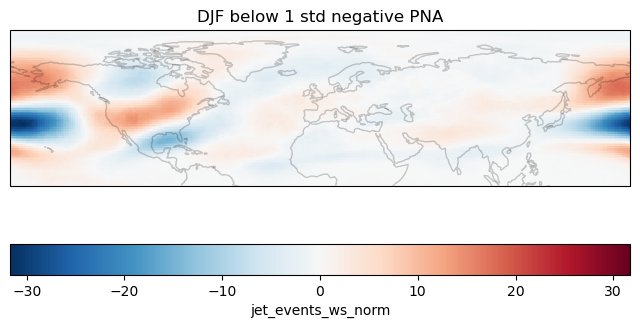

In [51]:
fig, ax = plt.subplots(1, figsize=(8, 5), subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
k06_below_1std_PNA['jet_events_ws_norm'].mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal'})
ax.set_title(f'DJF below 1 std negative PNA')
# fig.savefig('figures/djf_negativePNA_comparison_map.png', bbox_inches='tight', dpi=300)